# Making inference with pretrained UNet and B-UNet models

Define functions and set up environment

In [1]:
import torch
import sys
sys.path.append("/media/hdd/viscent/SR-UNet")
from models.unet3d.model import BUNet3D,UNet3D

import os 
import numpy as np
import SimpleITK as sitk
import ants
%matplotlib inline
import matplotlib.pyplot as plt
import torch.nn as nn
from mpl_toolkits.axes_grid1 import make_axes_locatable
from torchviz import make_dot
from colossalai.utils import load_checkpoint
from colossalai.initialize import launch,initialize
import colossalai
from colossalai.trainer import Trainer, hooks
import h5py as h5
from dataloaders import get_synth_dhcp_dataloader, get_synth_hcp_dataloader
import torchio as tio

from ipywidgets import interact, fixed
from IPython.display import clear_output

In [2]:
# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space.
def display_image(image_z, image):
    img = image[:, :, image_z]
    plt.imshow(sitk.GetArrayViewFromImage(img), cmap=plt.cm.Greys_r)
    plt.axis("off")
    plt.show()

def display_multiplanar(image):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.imshow(image[image.shape[0]//2,:,:], cmap=plt.cm.Greys_r)
    ax1.axis("off")
    ax2.imshow(image[:,image.shape[1]//2,:], cmap=plt.cm.Greys_r)
    ax2.axis("off")
    ax3.imshow(image[:,:,image.shape[2]//2], cmap=plt.cm.Greys_r)
    ax3.axis("off")
    plt.show()

def display_images(image_z, image_0, image_1):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(image_0[:, :, image_z], cmap=plt.cm.Greys_r)
    ax1.axis("off")
    ax2.imshow(image_1[:, :, image_z], cmap=plt.cm.Greys_r)
    ax2.axis("off")
    

def load_model(model_path:str):
    model = torch.load(model_path)
    model.train()
    return model

def load_image(mode :str = 'h5', 
               paths = ['/home/viscent/hdd/dhcp/dhcp_lores/preprocessed_h5/sub-CC00582XX14.h5'],
               dataset = 'dhcp',
               data_dir = '/home/viscent/hdd/dhcp/dhcp_lores/',):
    if mode == 'h5':
        with h5.File(paths[0],'r') as f:
            image = f['image_t1'][...].astype(np.float32)
            target = f['gt_t1'][...].astype(np.float32)
        image_tensor = torch.from_numpy(image).unsqueeze(0).unsqueeze(0).cuda()
        target_tensor = torch.from_numpy(target).unsqueeze(0).unsqueeze(0).cuda()
        return image_tensor,target_tensor
    elif mode == 'sitk':
        image = sitk.ReadImage(paths[0])
        target = sitk.ReadImage(paths[1])
        image = sitk.GetArrayFromImage(image)
        target = sitk.GetArrayFromImage(target)
        image_tensor = torch.from_numpy(image).unsqueeze(0).unsqueeze(0).cuda()
        target_tensor = torch.from_numpy(target).unsqueeze(0).unsqueeze(0).cuda()
        return image_tensor,target_tensor
    elif mode == 'npy':
        image = np.load(paths[0])
        target = np.load(paths[1])
        image_tensor = torch.from_numpy(image).unsqueeze(0).cuda()
        target_tensor = torch.from_numpy(target).unsqueeze(0).cuda()
        return image_tensor,target_tensor
    elif mode == 'dataloader':
        if dataset == 'dhcp':
            dataloaders, val_loader = get_synth_dhcp_dataloader(data_dir=data_dir,
                                                                batch_size=1,
                                                                num_samples=50,
                                                                input_modalities=["t1"],
                                                                output_modalities=["t1"],
                                                                output_dir=data_dir,
                                                                n_splits=5,
                                                                augmentation=False,
                                                                down_factor=5,)
        elif dataset == 'hcp':
            dataloaders, val_loader = get_synth_hcp_dataloader(data_dir=data_dir,
                                                                batch_size=1,
                                                                num_samples=50,
                                                                input_modalities=["t1"],
                                                                output_modalities=["t1"],
                                                                output_dir=data_dir,
                                                                n_splits=5,
                                                                augmentation=False,
                                                                down_factor=5,)
        image_tensor, target_tensor = next(iter(val_loader))
        image_tensor = image_tensor.cuda()
        target_tensor = target_tensor.cuda()
        return image_tensor,target_tensor

def plot_latent(model):
    encoder_weights = next(model.encoders[-1].parameters())
    encoder_weights = encoder_weights.cpu().detach().numpy()
    encoder_weights= np.expand_dims(encoder_weights,axis=1)
    encoder_weights = np.repeat(encoder_weights, 128, axis=1)
    if hasattr(model, 'enc_mu'):
        fig,(ax1,ax2) = plt.subplots(1,2)
        im1 = ax1.imshow(encoder_weights)
        ax1.set_title("encoder weights")
        divider = make_axes_locatable(ax1)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im1, cax=cax, orientation="vertical")

        latent_weights = next(model.mu.parameters())
        latent_weights = latent_weights.cpu().detach().numpy()
        latent_weights = np.repeat(latent_weights, 128, axis=1)

        im2 = ax2.imshow(encoder_weights)
        ax2.set_title("latent weights")
        divider = make_axes_locatable(ax2)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im2, cax=cax, orientation="vertical")
        fig.show()
    else:
        fig = plt.imshow(encoder_weights)
        plt.title("encoder weights")
        plt.colorbar()
        plt.show()
    # plt.savefig(OUTPUT_PREFIX+"_encoder_weights.png")

def infer(model,image_tensor):
    output_tensor = model(image_tensor)
    return output_tensor

def get_metrics(output_tensor,target_tensor, model, mu_q = None, logvar_q = None):
    im = target_tensor
    im_hat = output_tensor
    mse = torch.nn.MSELoss()(im, im_hat)
    mse.backward()
    print('mse:', mse.cpu().detach().numpy())
    if hasattr(model, 'enc_mu'):
        # mu_p, logvar_p = model.enc_mu,model.enc_logvar
        # # kl = (0.5 * ((torch.ones_like(logvar_p)-torch.ones_like(logvar_p)) + (mu_p-mu_q)**2 / torch.ones_like(logvar_p).exp() - 1 + (torch.ones_like(logvar_p)).exp() / (torch.ones_like(logvar_p)).exp() )).sum()
        # # kl = (0.5 * ((logvar_q-logvar_p) + (mu_p-mu_q)**2 / logvar_q.exp() - 1 + logvar_p.exp() / logvar_q.exp())).mean()
        # kl = 0.5 * (logvar_p.exp() + mu_p**2 - 1 - logvar_p).sum()
        # # kl = 0.5 * ((logvar_q-logvar_p) - 3 + (mu_p - mu_q) / logvar_q.exp() * (mu_p-mu_q) + torch.trace)
        # # kl = torch.sum(kl)

        ###### kl divergence with covariance ######
        mu_p = model.enc_mu.flatten()
        logvar_p = model.enc_logvar.flatten()

        cov_p = torch.exp(logvar_p)
        cov_p[cov_p.isnan()] = cov_p.mean()
        cov_p[cov_p == 0] = cov_p.mean()
        cov_p = cov_p.diag()
        cov_q = torch.exp(logvar_q)
        cov_q[cov_q.isnan()] = cov_q.mean()
        cov_q[cov_q == 0] = cov_q.mean()
        cov_q = cov_q.diag()
        k = mu_p.shape[0]

        tmp = ((mu_p-mu_q)**2 / torch.exp(logvar_q))
        tmp[tmp.isnan()] = tmp.median()
        tmp[tmp.isinf()] = tmp.median()
        tmp = tmp.sum()
        kl = 0.5 *( logvar_q.sum() - logvar_p.sum() - k + tmp + (torch.exp(logvar_p-logvar_q).sum()))
        kl
        ###########################################


        FE_simple = mse + 0.00025 * kl
        print('kl:', kl.cpu().detach().numpy())
        print('Free energy:', FE_simple.cpu().detach().numpy())

def plot_output(image_tensor,output_tensor,target_tensor):
    image_tensor = image_tensor.cpu().squeeze().squeeze().detach().numpy().astype(np.float32)
    output_tensor = output_tensor.cpu().squeeze().squeeze().detach().numpy().astype(np.float32)
    target_tensor = target_tensor.cpu().squeeze().squeeze().detach().numpy().astype(np.float32)
    fig,(ax1,ax2,ax3) = plt.subplots(1,3)
    im1 = ax1.imshow(image_tensor[image_tensor.shape[0]//2,:,:],cmap='gray')
    ax1.set_title("image")


    im2 = ax2.imshow(output_tensor[output_tensor.shape[0]//2,:,:],cmap='gray')
    ax2.set_title("output")
    
    
    im3 = ax3.imshow(target_tensor[target_tensor.shape[0]//2,:,:],cmap='gray')
    ax3.set_title("target")
    fig.show()
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the
# metric_values list.
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))
    
def registration_sitk(fixed_image, moving_image):
    initial_transform = sitk.CenteredTransformInitializer(
        fixed_image,
        moving_image,
        sitk.Euler3DTransform(),
        sitk.CenteredTransformInitializerFilter.GEOMETRY,
    )

    moving_resampled = sitk.Resample(
        moving_image,
        fixed_image,
        initial_transform,
        sitk.sitkLinear,
        0.0,
        moving_image.GetPixelID(),
    )
    registration_method = sitk.ImageRegistrationMethod()

    # Similarity metric settings.
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)

    registration_method.SetInterpolator(sitk.sitkLinear)

    # Optimizer settings.
    registration_method.SetOptimizerAsGradientDescent(
        learningRate=1.0,
        numberOfIterations=100,
        convergenceMinimumValue=1e-6,
        convergenceWindowSize=10,
    )
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # Setup for the multi-resolution framework.
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # Don't optimize in-place, we would possibly like to run this cell multiple times.
    registration_method.SetInitialTransform(initial_transform, inPlace=False)


    final_transform = registration_method.Execute(
        sitk.Cast(fixed_image, sitk.sitkFloat32), sitk.Cast(moving_image, sitk.sitkFloat32)
    )
    moving_resampled = sitk.Resample(
        moving_image,
        fixed_image,
        final_transform,
        sitk.sitkLinear,
        0.0,
        moving_image.GetPixelID(),
    )
    return moving_resampled

def resample(image):
    target_shape = (108, 145, 145)
    spacing = [1.0,1.0,1.0]
    spacing = np.array(spacing)
    resample_transform = tio.Resample(target=spacing)
    resize_transform = tio.Resize(target_shape=target_shape)
    transform  = tio.Compose([resample_transform,resize_transform])
    return transform(image)

def downSample(image):
    spacing = [1.0,1.0,1.0]
    spacing = np.array(spacing)
    spacing *= 5
    target_shape = (108, 145, 145)
    resize_transform = tio.Resize(target_shape=target_shape)
    resample_transform = tio.Resample(target=spacing)
    blur_transform = tio.RandomBlur(3)
    transform  = tio.Compose([resample_transform,resize_transform,blur_transform])
    return transform(image)


def registration_ants(fixed_image, moving_image):
    fixed_array = sitk.GetArrayFromImage(fixed_image)
    moving_array = sitk.GetArrayFromImage(moving_image)
    fixed_ants = ants.from_numpy(fixed_array)
    moving_ants = ants.from_numpy(moving_array)
    ret = ants.registration(fixed_ants, moving_ants,verbose=True)
    image = ret['warpedmovout'].numpy()
    image = sitk.GetImageFromArray(image)
    image.CopyInformation(fixed_image)
    return image

import matplotlib
def rgb_white2alpha(rgb, ensure_increasing=False, ensure_linear=False, lsq_linear=False):
    """
    Convert a set of RGB colors to RGBA with maximum transparency.

    The transparency is maximised for each color individually, assuming
    that the background is white.

    Parameters
    ----------
    rgb : array_like shaped (N, 3)
        Original colors.
    ensure_increasing : bool, default=False
        Ensure that alpha values increase monotonically.
    ensure_linear : bool, default=False
        Ensure alpha values increase linear from initial to final value.
    lsq_linear : bool, default=False
        Use least-squares linear fit for alpha.

    Returns
    -------
    rgba : numpy.ndarray shaped (N, 4)
        Colors with maximum possible transparency, assuming a white
        background.
    """
    # The most transparent alpha we can use is given by the min of RGB
    # Convert it from saturation to opacity
    alpha = 1. - np.min(rgb, axis=1)
    if lsq_linear:
        # Make a least squares fit for alpha
        indices = np.arange(len(alpha))
        A = np.stack([indices, np.ones_like(indices)], axis=-1)
        m, c = np.linalg.lstsq(A, alpha, rcond=None)[0]
        # Use our least squares fit to generate a linear alpha
        alpha = c + m * indices
        alpha = np.clip(alpha, 0, 1)
    elif ensure_linear:
        # Use a linearly increasing/decreasing alpha from start to finish
        alpha = np.linspace(alpha[0], alpha[-1], rgb.shape[0])
    elif ensure_increasing:
        # Let's also ensure the alpha value is monotonically increasing
        a_max = alpha[0]
        for i, a in enumerate(alpha):
            alpha[i] = a_max = np.maximum(a, a_max)
    alpha = np.expand_dims(alpha, -1)
    # Rescale colors to discount the white that will show through from transparency
    rgb = (rgb + alpha - 1)
    rgb = np.divide(rgb, alpha, out=np.zeros_like(rgb), where=(alpha > 0))
    rgb = np.clip(rgb, 0, 1)
    # Concatenate our alpha channel
    rgba = np.concatenate((rgb, alpha), axis=1)
    return rgba
def cmap_white2alpha(name, ensure_increasing=False, ensure_linear=False, lsq_linear=False, register=True):

    """
    Add as much transparency as possible to a colormap, assuming white background.

    Parameters
    ----------
    name : str
        Name of builtin (or registered) colormap.
    ensure_increasing : bool, default=False
        Ensure that alpha values are strictly increasing.
    ensure_linear : bool, default=False
        Ensure alpha values increase linear from initial to final value.
    lsq_linear : bool, default=False
        Use least-squares linear fit for alpha.
    register : bool, default=True
        Whether to register the new colormap.

    Returns
    -------
    cmap : matplotlib.colors.ListedColormap
        Colormap with alpha set as low as possible.
    """
    # Fetch the cmap callable
    cmap = plt.get_cmap(name)
    # Get the colors out from the colormap LUT
    rgb = cmap(np.arange(cmap.N))[:, :3]  # N-by-3
    # Convert white to alpha
    rgba = rgb_white2alpha(
        rgb,
        ensure_increasing=ensure_increasing,
        ensure_linear=ensure_linear,
        lsq_linear=lsq_linear,
    )
    # Create a new Colormap object
    new_name = name + "_white2alpha"
    cmap_alpha = matplotlib.colors.ListedColormap(rgba, name=new_name)
    if register:
        matplotlib.cm.register_cmap(name=new_name, cmap=cmap_alpha)
    return cmap_alpha

In [3]:
model_vae_dhcp = load_model('/media/hdd/viscent/create-models/20220706/vae_dhcp/160.pth')
model_vae_hcp = load_model('/media/hdd/viscent/create-models/20220706/vae_hcp/91.pth')
model_unet_dhcp = load_model('/media/hdd/viscent/create-models/20220607/unet_dhcp/299.pth')
model_unet_hcp = load_model('/media/hdd/viscent/create-models/20220607/unet_hcp/299.pth')

mu_vae_dhcp = model_vae_dhcp.enc_mu[0].flatten()
logvar_vae_dhcp = model_vae_dhcp.enc_logvar[0].flatten()
mu_vae_hcp = model_vae_hcp.enc_mu[0].flatten()
logvar_vae_hcp = model_vae_hcp.enc_logvar[0].flatten()

## Results on dHCP

In [141]:
image_tensor,target_tensor = load_image()
image_tensor_dHCP = image_tensor.clone()
target_tensor_dHCP = target_tensor.clone()

### Debug

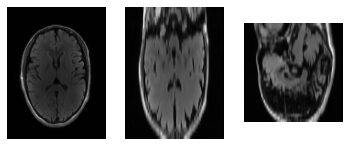

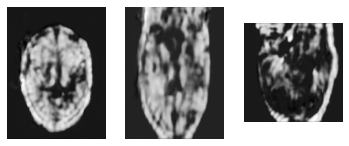

interactive(children=(IntSlider(value=108, description='image_z', max=324, min=-108), Output()), _dom_classes=…

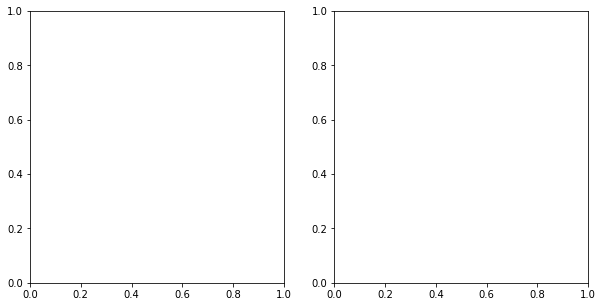

In [136]:
image_path = "/media/hdd/viscent/SR-UNet/inference/Yiqi_FLAIR.nii.gz"
image = sitk.ReadImage(image_path)
image = resample(image)
image_array = sitk.GetArrayFromImage(image).astype(np.float32)
image_tensor = torch.from_numpy(image_array).unsqueeze(0).unsqueeze(0).cuda()
output_tensor = model_vae_hcp(image_tensor)
output_array = output_tensor.detach().cpu().numpy()[0,0]
display_multiplanar(image_array)
display_multiplanar(output_array)
interact(
    display_images,
    image_z=image_array.shape[2],
    image_0=fixed(image_array),
    image_1=fixed(output_array),
);

### VAE-dHCP

mse: 0.20986085
kl: 5.398839e+28
Free energy: 1.3497098e+25


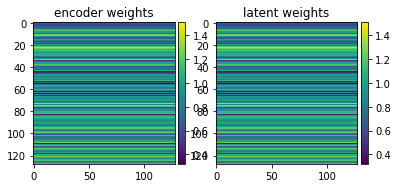

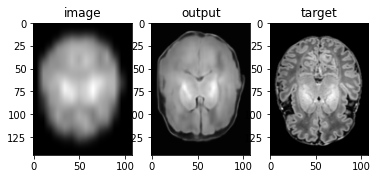

In [142]:
plot_latent(model_vae_dhcp)
output_tensor = infer(model_vae_dhcp,image_tensor)
get_metrics(output_tensor,target_tensor,model_vae_dhcp, mu_q= mu_vae_dhcp, logvar_q= logvar_vae_dhcp)
plot_output(image_tensor,output_tensor,target_tensor)
dhcp_tensor = output_tensor.clone()
rsqe_dhcp = (output_tensor - target_tensor).pow(2).sqrt()
rsqe_dhcp = rsqe_dhcp.detach().cpu().numpy()[0,0]

### VAE-HCP

mse: 0.1835985
kl: 3.8181574e+33
Free energy: 9.545394e+29


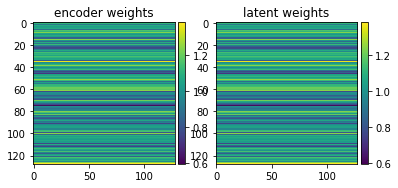

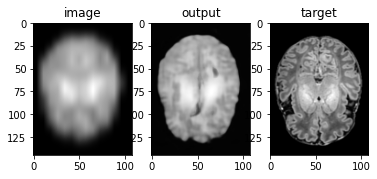

In [143]:
plot_latent(model_vae_hcp)
output_tensor = infer(model_vae_hcp,image_tensor)
get_metrics(output_tensor,target_tensor,model_vae_hcp, mu_q= mu_vae_hcp, logvar_q= logvar_vae_hcp)
plot_output(image_tensor,output_tensor,target_tensor)
hcp_tensor = output_tensor.clone()
rsqe_hcp = (output_tensor - target_tensor).pow(2).sqrt()
rsqe_hcp = rsqe_hcp.detach().cpu().numpy()[0,0]

/tmp/ipykernel_2716208/1283782319.py:14: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "Transparent" which is no longer supported as of 3.3 and will become an error in 3.6



<Figure size 432x288 with 0 Axes>

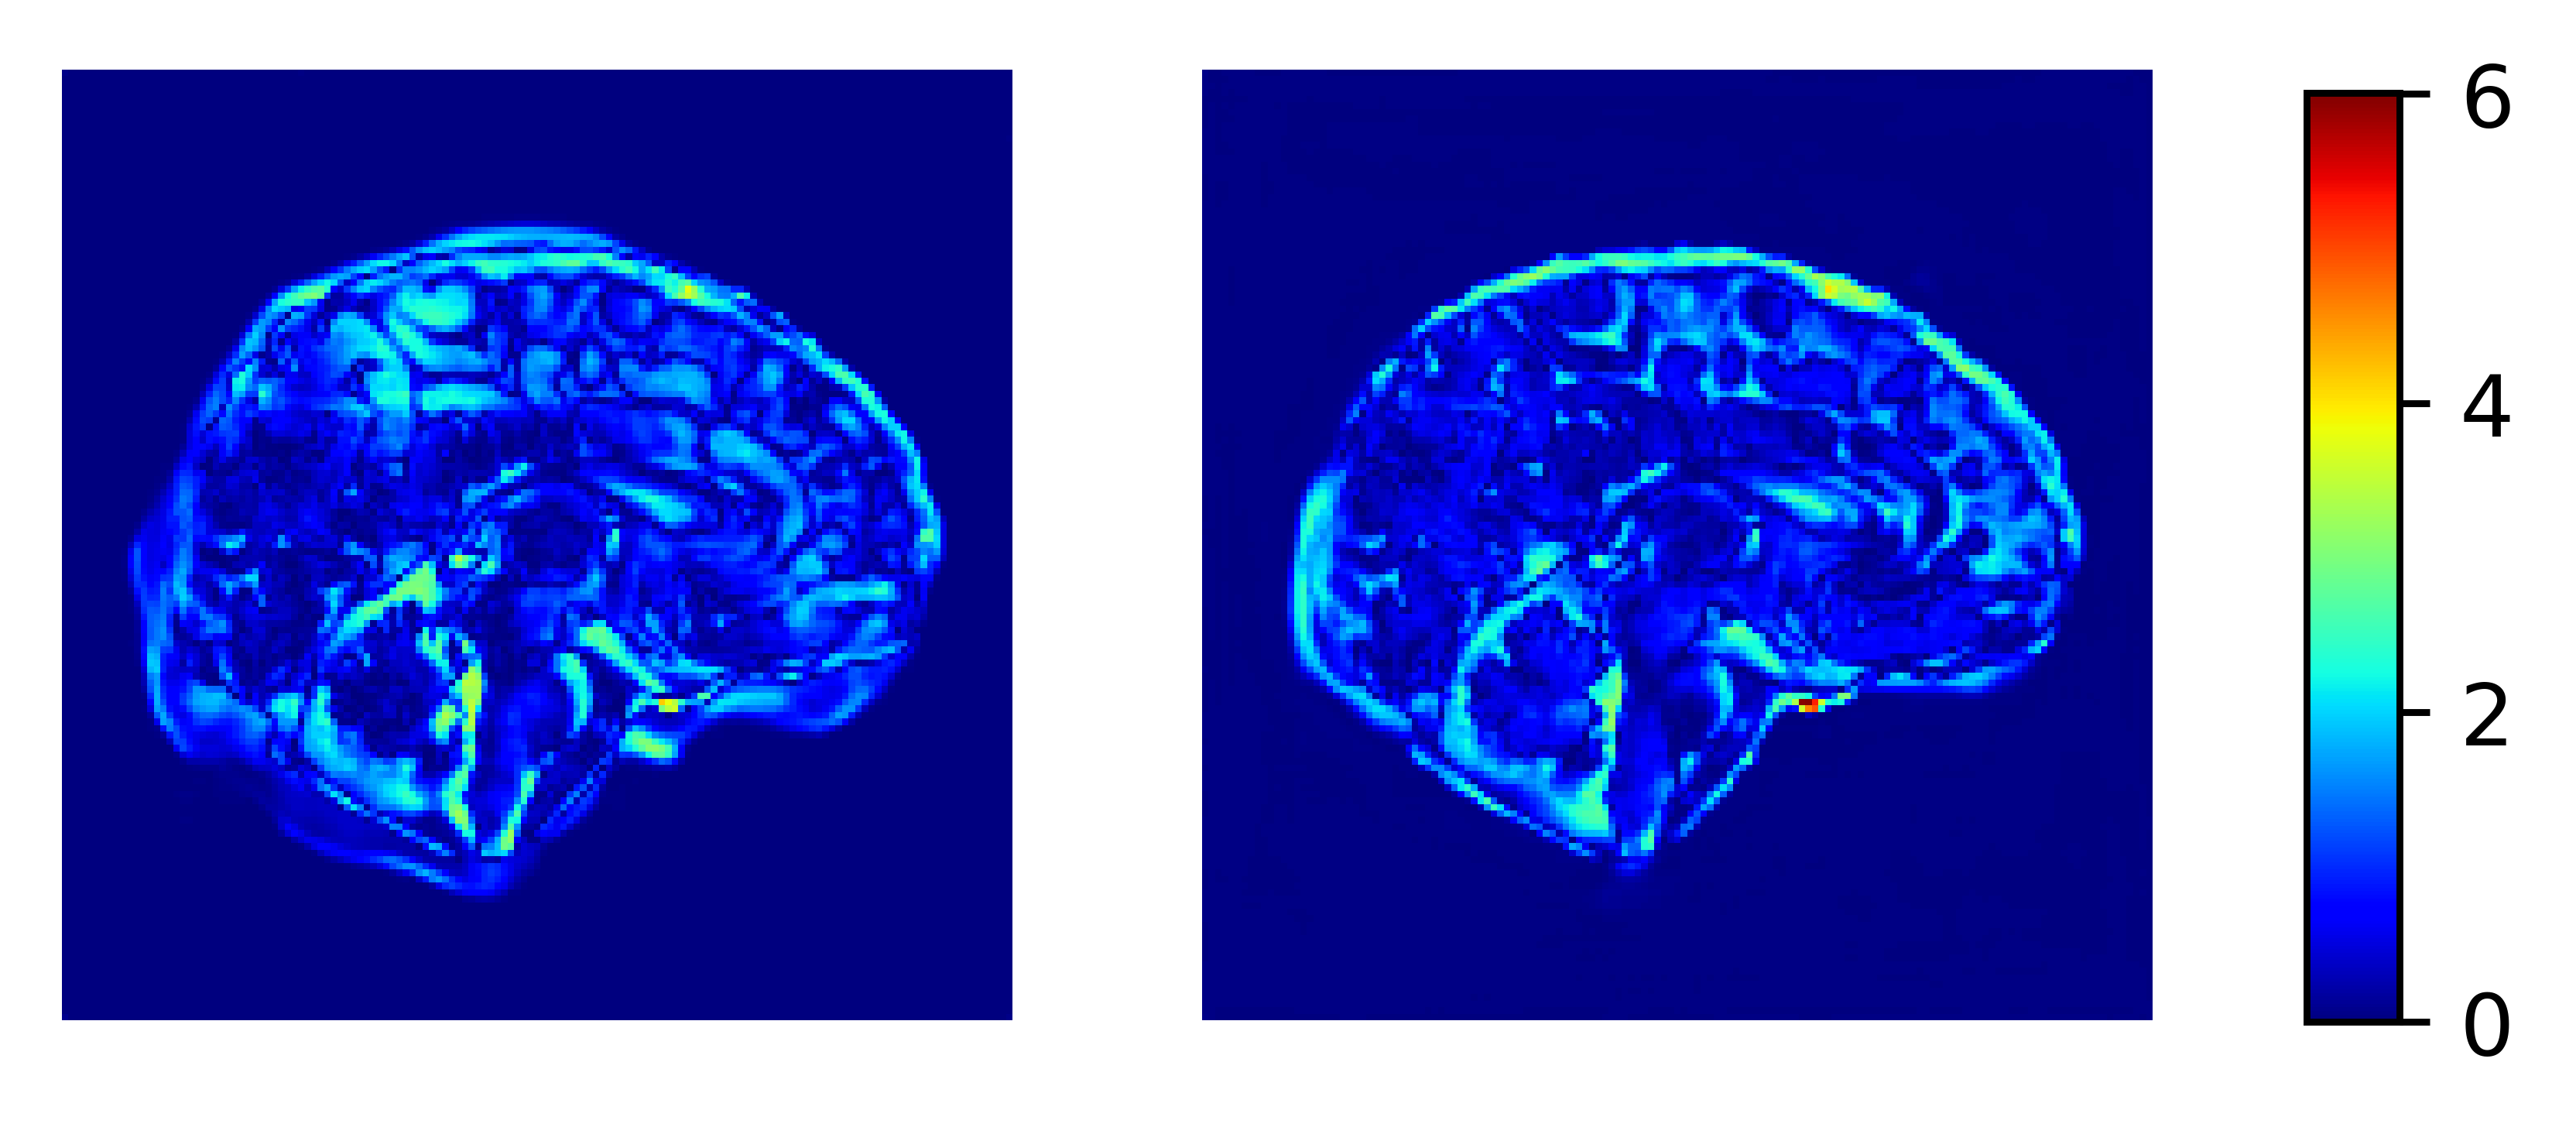

In [147]:
plt.clf()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,10), dpi = 800)
array_dhcp = rsqe_dhcp[::-1,:,rsqe_dhcp.shape[2]//2]
array_hcp = rsqe_hcp[::-1,:,rsqe_hcp.shape[2]//2]
zlim = (0,max(np.abs(rsqe_dhcp).max(), np.abs(rsqe_hcp).max()))
im1 = ax1.imshow(array_dhcp, cmap='jet', vmin=zlim[0], vmax=zlim[1])
im2 = ax2.imshow(array_hcp, cmap='jet', vmin=zlim[0], vmax=zlim[1])
ax1.axis('off')
ax2.axis('off')
#add colorbar
fig.subplots_adjust(right=0.8)
cbax = fig.add_axes([0.85, 0.4255, 0.03, 0.15])
fig.colorbar(im1, ax=[ax1, ax2], cax=cbax)
plt.savefig("/media/hdd/viscent/SR-UNet/inference/publish/dHCP_error.png", dpi=800, Transparent=True)

### UNET-dHCP

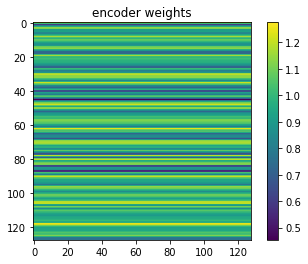

mse: 0.0374123


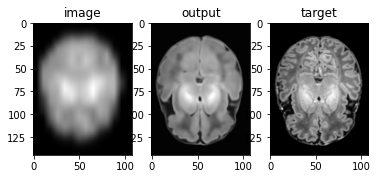

In [13]:
plot_latent(model_unet_dhcp)
output_tensor = infer(model_unet_dhcp,image_tensor)
get_metrics(output_tensor,target_tensor,model_unet_dhcp)
plot_output(image_tensor,output_tensor,target_tensor)

### UNET-HCP

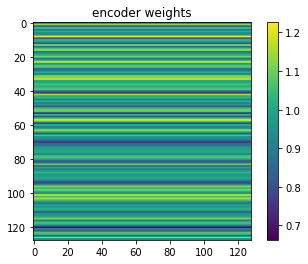

mse: 0.18996984


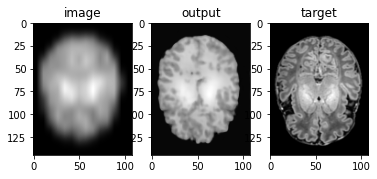

In [14]:
plot_latent(model_unet_hcp)
output_tensor = infer(model_unet_hcp,image_tensor)
get_metrics(output_tensor,target_tensor,model_unet_hcp)
plot_output(image_tensor,output_tensor,target_tensor)

## Results on HCP

In [148]:
image_tensor,target_tensor = load_image(mode='h5',paths=['/media/hdd/HCP_1200/preprocessed_h5/100206.h5'])
image_tensor_HCP = image_tensor.clone()
target_tensor_HCP = target_tensor.clone()

### VAE-dHCP

mse: 0.111944504
kl: 1.1433957e+29
Free energy: 2.8584895e+25


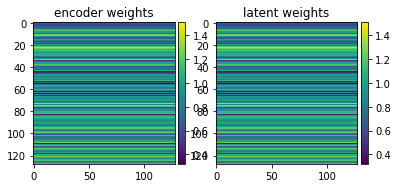

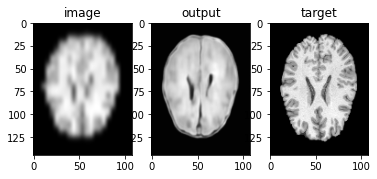

In [149]:
plot_latent(model_vae_dhcp)
output_tensor = infer(model_vae_dhcp,image_tensor)
get_metrics(output_tensor,target_tensor,model_vae_dhcp, mu_q= mu_vae_dhcp, logvar_q= logvar_vae_dhcp)
plot_output(image_tensor,output_tensor,target_tensor)
dhcp_tensor = output_tensor.clone()
rsqe_dhcp = (output_tensor - target_tensor).pow(2).sqrt()
rsqe_dhcp = rsqe_dhcp.detach().cpu().numpy()[0,0]

### VAE-HCP

mse: 0.037305634
kl: 3.690263e+32
Free energy: 9.225658e+28


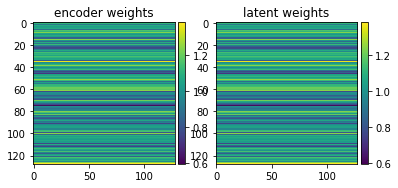

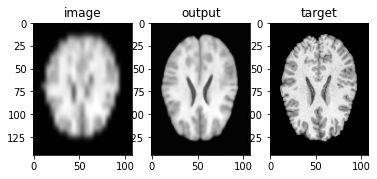

In [150]:
plot_latent(model_vae_hcp)
output_tensor = infer(model_vae_hcp,image_tensor)
get_metrics(output_tensor,target_tensor,model_vae_hcp, mu_q= mu_vae_hcp, logvar_q= logvar_vae_hcp)
plot_output(image_tensor,output_tensor,target_tensor)
hcp_tensor = output_tensor.clone()
rsqe_hcp = (output_tensor - target_tensor).pow(2).sqrt()
rsqe_hcp = rsqe_hcp.detach().cpu().numpy()[0,0]

/tmp/ipykernel_2716208/2311207855.py:13: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "Transparent" which is no longer supported as of 3.3 and will become an error in 3.6



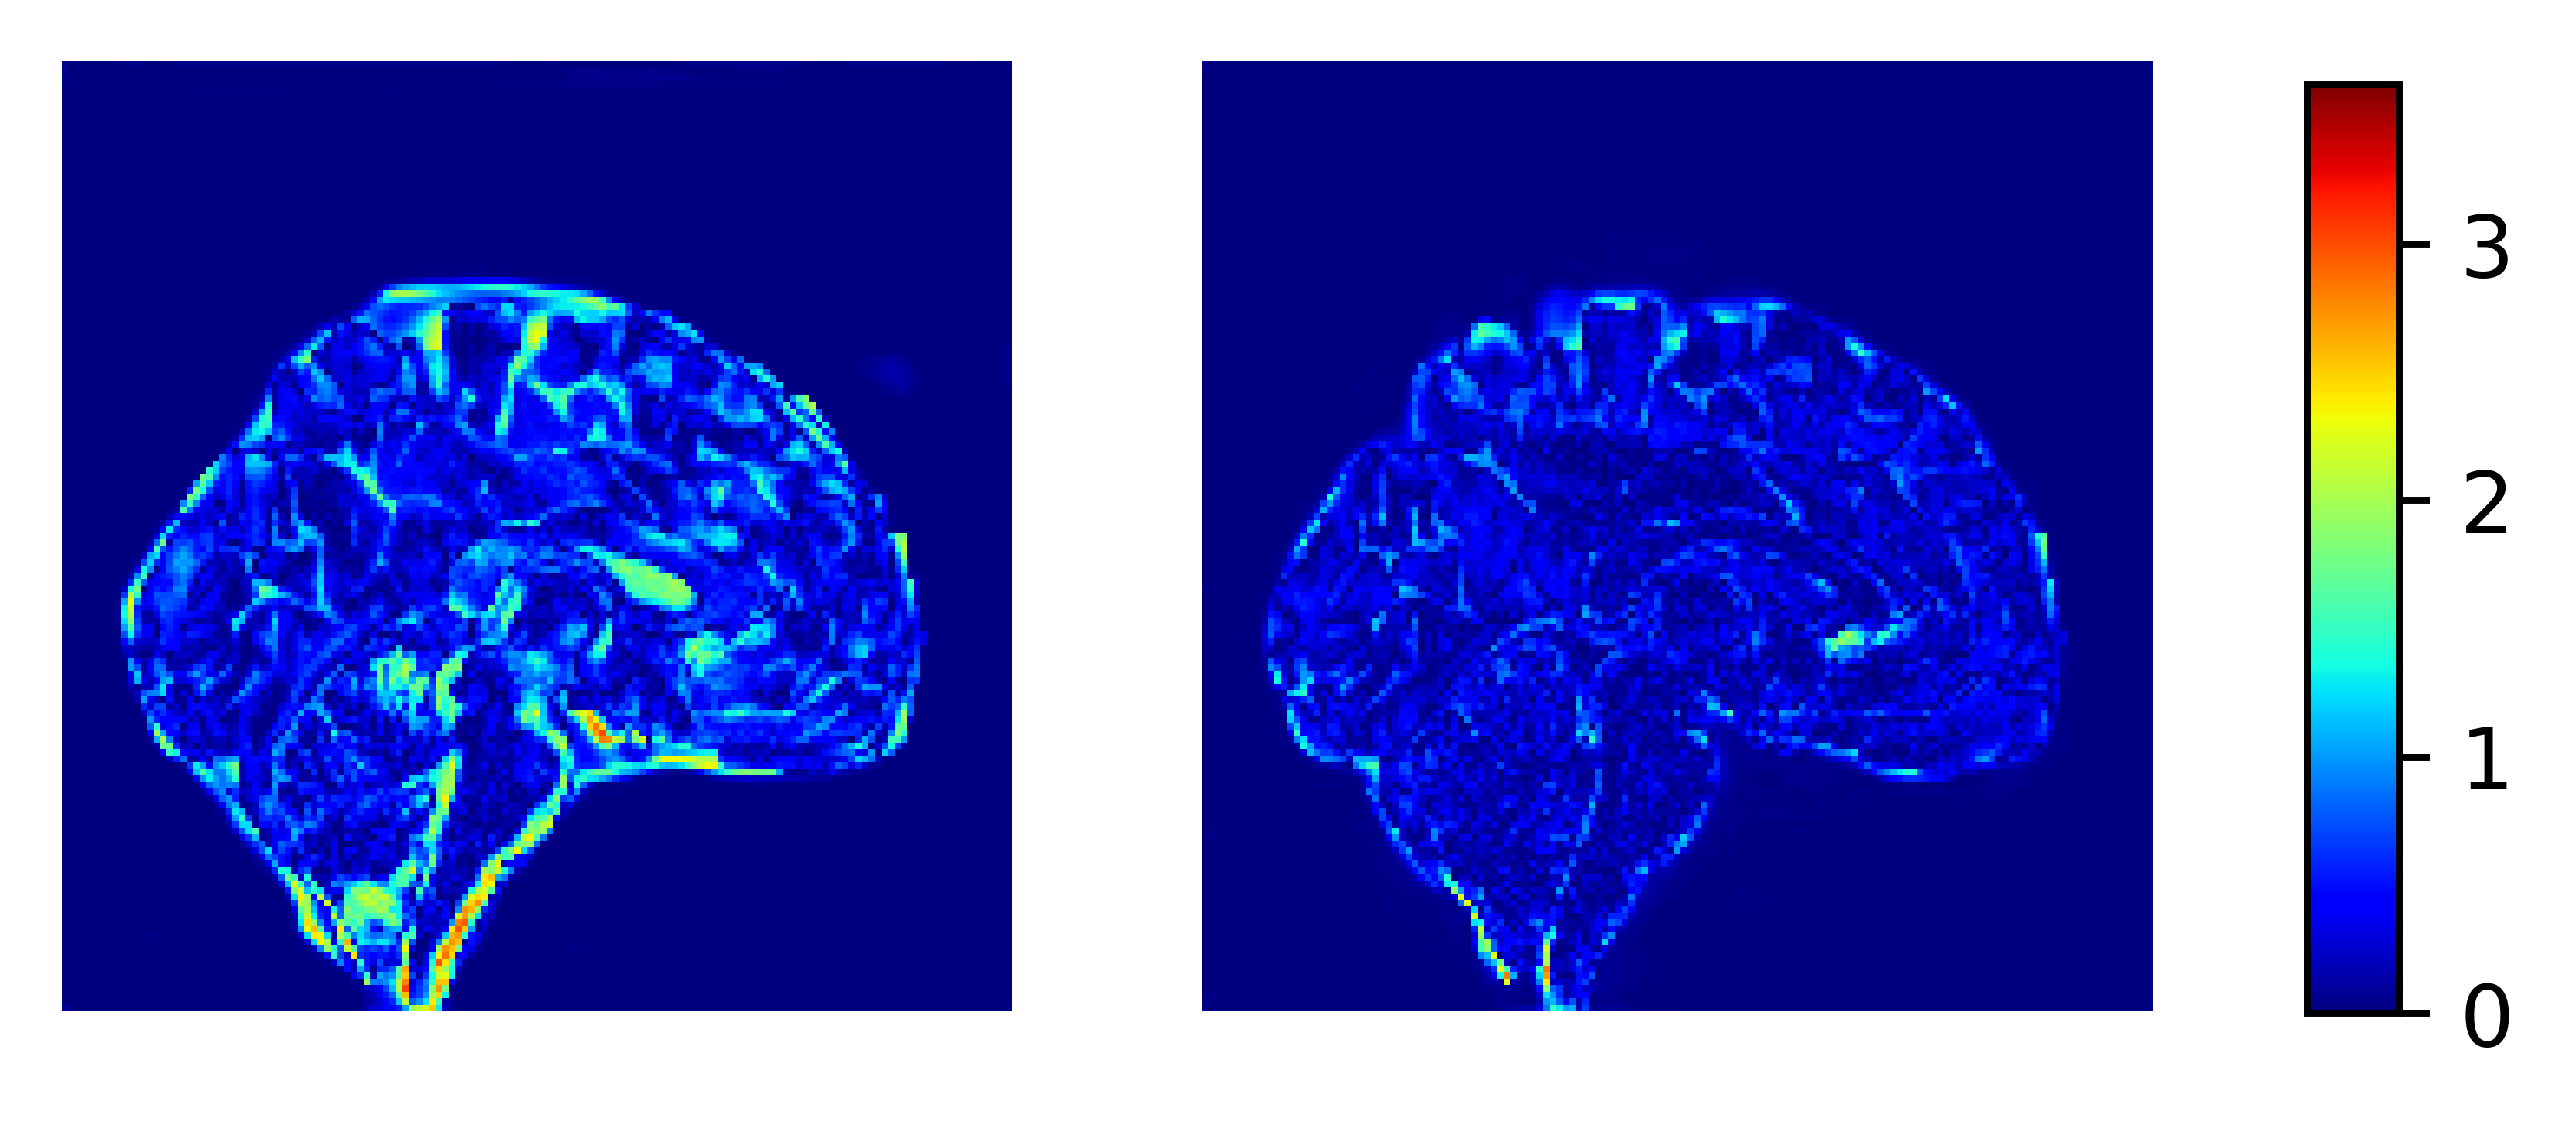

In [151]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,10), dpi = 800)
array_dhcp = rsqe_dhcp[::-1,:,rsqe_dhcp.shape[2]//2]
array_hcp = rsqe_hcp[::-1,:,rsqe_hcp.shape[2]//2]
zlim = (0,max(np.abs(rsqe_dhcp).max(), np.abs(rsqe_hcp).max()))
im1 = ax1.imshow(array_dhcp, cmap='jet', vmin=zlim[0], vmax=zlim[1])
im2 = ax2.imshow(array_hcp, cmap='jet', vmin=zlim[0], vmax=zlim[1])
ax1.axis('off')
ax2.axis('off')
#add colorbar
fig.subplots_adjust(right=0.8)
cbax = fig.add_axes([0.85, 0.4255, 0.03, 0.15])
fig.colorbar(im1, ax=[ax1, ax2], cax=cbax)
plt.savefig("/media/hdd/viscent/SR-UNet/inference/publish/HCP_error.png", dpi=800, Transparent=True)

In [162]:

image_array = image_tensor.detach().cpu().numpy()[0,0,::-1]
output_array = output_tensor.detach().cpu().numpy()[0,0,::-1]
target_array = target_tensor.detach().cpu().numpy()[0,0,::-1]
plt.clf()
plt.imshow(image_array[image_array.shape[0]//2,:,:], cmap='gray')
plt.savefig("/media/hdd/viscent/SR-UNet/inference/publish/image_HCP_x.png", dpi=800, Transparent=True)
plt.clf()
plt.imshow(output_array[output_array.shape[0]//2,:,:], cmap='gray')
plt.savefig("/media/hdd/viscent/SR-UNet/inference/publish/output_HCP_x.png", dpi=800, Transparent=True)
plt.clf()
plt.imshow(target_array[target_array.shape[0]//2,:,:], cmap='gray')
plt.savefig("/media/hdd/viscent/SR-UNet/inference/publish/target_HCP_x.png", dpi=800, Transparent=True)
plt.clf()
plt.imshow(image_array[:,image_array.shape[1]//2,:], cmap='gray')
plt.savefig("/media/hdd/viscent/SR-UNet/inference/publish/image_HCP_y.png", dpi=800, Transparent=True)
plt.clf()
plt.imshow(output_array[:,output_array.shape[1]//2,:], cmap='gray')
plt.savefig("/media/hdd/viscent/SR-UNet/inference/publish/output_HCP_y.png", dpi=800, Transparent=True)
plt.clf()
plt.imshow(target_array[:,target_array.shape[1]//2,:], cmap='gray')
plt.savefig("/media/hdd/viscent/SR-UNet/inference/publish/target_HCP_y.png", dpi=800, Transparent=True)
plt.clf()
plt.imshow(image_array[:,:,image_array.shape[2]//2], cmap='gray')
plt.savefig("/media/hdd/viscent/SR-UNet/inference/publish/image_HCP_z.png", dpi=800, Transparent=True)
plt.clf()
plt.imshow(output_array[:,:,image_array.shape[2]//2], cmap='gray')
plt.savefig("/media/hdd/viscent/SR-UNet/inference/publish/output_HCP_z.png", dpi=800, Transparent=True)
plt.clf()   
plt.imshow(target_array[:,:,image_array.shape[2]//2], cmap='gray')
plt.savefig("/media/hdd/viscent/SR-UNet/inference/publish/target_HCP_z.png", dpi=800, Transparent=True)
plt.clf()

/tmp/ipykernel_2716208/1891161656.py:6: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "Transparent" which is no longer supported as of 3.3 and will become an error in 3.6

/tmp/ipykernel_2716208/1891161656.py:9: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "Transparent" which is no longer supported as of 3.3 and will become an error in 3.6

/tmp/ipykernel_2716208/1891161656.py:12: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "Transparent" which is no longer supported as of 3.3 and will become an error in 3.6

/tmp/ipykernel_2716208/1891161656.py:15: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "Transparent" which is no longer supported as of 3.3 and will become an error in 3.6

/tmp/ipykernel_2716208/1891161656.py:18: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "Transparent" which is no longer supported as of 3.3 and will become an error in 3.6

/t

<Figure size 432x288 with 0 Axes>

In [158]:
plt.clf()
image_array = image_tensor.detach().cpu().numpy()[0,0]
output_array = output_tensor.detach().cpu().numpy()[0,0]
target_array = target_tensor.detach().cpu().numpy()[0,0]
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8,ax9)) = plt.subplots(3, 3, figsize=(15,10), dpi = 800)
ax1.imshow(image_array[:,:,image_array.shape[2]//2], cmap=plt.cm.Greys_r)
ax1.axis('off')
ax2.imshow(image_array[:,image_array.shape[2]//2,:], cmap=plt.cm.Greys_r)
ax2.axis('off')
ax3.imshow(image_array[image_array.shape[2]//2,:,:], cmap=plt.cm.Greys_r)
ax3.axis('off')
ax4.imshow(output_array[:,:,output_array.shape[2]//2], cmap=plt.cm.Greys_r)
ax4.axis('off')
ax5.imshow(output_array[:,output_array.shape[2]//2,:], cmap=plt.cm.Greys_r)
ax5.axis('off')
ax6.imshow(output_array[output_array.shape[2]//2,:,:], cmap=plt.cm.Greys_r)
ax6.axis('off')
ax7.imshow(target_array[:,:,target_array.shape[2]//2], cmap=plt.cm.Greys_r)
ax7.axis('off')
ax8.imshow(target_array[:,target_array.shape[2]//2,:], cmap=plt.cm.Greys_r)
ax8.axis('off')
ax9.imshow(target_array[target_array.shape[2]//2,:,:], cmap=plt.cm.Greys_r)
ax9.axis('off')
plt.savefig("/media/hdd/viscent/SR-UNet/inference/publish/HCP_images.png", dpi=800, Transparent=True)



/tmp/ipykernel_2716208/3481851272.py:24: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "Transparent" which is no longer supported as of 3.3 and will become an error in 3.6



<Figure size 432x288 with 0 Axes>

### UNET-dHCP

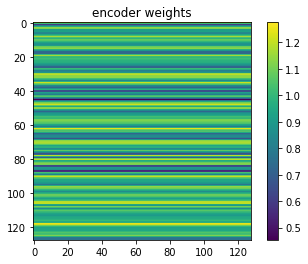

mse: 0.17149962


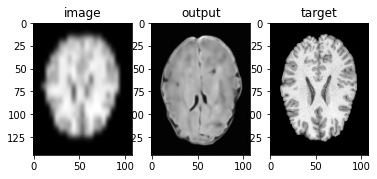

In [18]:
plot_latent(model_unet_dhcp)
output_tensor = infer(model_unet_dhcp,image_tensor)
get_metrics(output_tensor,target_tensor,model_unet_dhcp)
plot_output(image_tensor,output_tensor,target_tensor)

### UNET-HCP

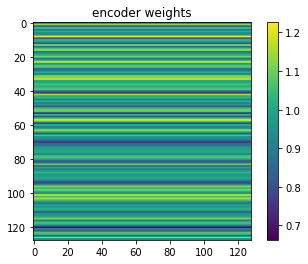

mse: 0.021776242


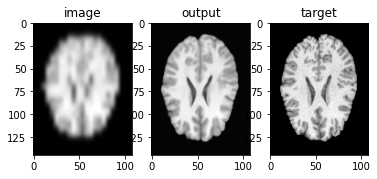

In [19]:
plot_latent(model_unet_hcp)
output_tensor = infer(model_unet_hcp,image_tensor)
get_metrics(output_tensor,target_tensor,model_unet_hcp)
plot_output(image_tensor,output_tensor,target_tensor)

## Cross-domain Evaluation

In [20]:
# fixed_image = sitk.ReadImage('/media/hdd/dhcp/dhcp_lores/preprocessed/sub-CC00446XX18_gt_t1.nii.gz', sitk.sitkFloat32)
# moving_image = sitk.ReadImage('/home/viscent/hdd/viscent/SR-UNet/data/001B/001B_mediumResShortTI.nii', sitk.sitkFloat32)
# moving_image = sitk.DICOMOrient(moving_image,'RAI')
# # Undo normalization

# temp_array = sitk.GetArrayFromImage(fixed_image)
# temp_array *= sitk.GetArrayFromImage(moving_image).max()
# temp_fixed = sitk.GetImageFromArray(temp_array)
# temp_fixed.CopyInformation(fixed_image)
# fixed_image = temp_fixed

# # fixed_image = downSample(fixed_image)
# moving_image = resample(moving_image)
# moving_ants = ants.from_numpy(sitk.GetArrayFromImage(moving_image))
# fixed_ants = ants.from_numpy(sitk.GetArrayFromImage(fixed_image))
# ret = ants.registration(fixed=fixed_ants, moving=moving_ants,verbose=True)
# target_tensor = torch.from_numpy(sitk.GetArrayFromImage(moving_image)).clone().unsqueeze(0).unsqueeze(0).cuda()
# image = downSample(moving_image)
# image_tensor = torch.from_numpy(sitk.GetArrayFromImage(moving_image)).unsqueeze(0).unsqueeze(0).cuda()

In [21]:
# moving_image.GetSpacing()

In [22]:
fixed_image = sitk.ReadImage('/media/hdd/dhcp/dhcp_lores/preprocessed/sub-CC00446XX18_gt_t1.nii.gz', sitk.sitkFloat32)
# moving_image = sitk.ReadImage('/media/hdd/ds001894/sub-001/ses-T1/anat/sub-001_ses-T1_T1w.nii.gz', sitk.sitkFloat32)
moving_image = sitk.ReadImage('/home/viscent/hdd/viscent/SR-UNet/data/reg.nii.gz', sitk.sitkFloat32)
# moving_image = sitk.ReadImage('/home/viscent/hdd/viscent/SR-UNet/data/T1.nii.gz', sitk.sitkFloat32)
# moving_image = sitk.DICOMOrient(moving_image,'RAI')

# Undo normalization

temp_array = sitk.GetArrayFromImage(fixed_image)
temp_array = (temp_array - temp_array.min()) / (temp_array.max() - temp_array.min()) * sitk.GetArrayFromImage(moving_image).max()
temp_fixed = sitk.GetImageFromArray(temp_array)
temp_fixed.CopyInformation(fixed_image)
fixed_image = temp_fixed

moving_image = resample(moving_image)

image = registration_ants(fixed_image,moving_image)
image = resample(image)
target_tensor = torch.from_numpy(sitk.GetArrayFromImage(image)).clone().unsqueeze(0).unsqueeze(0).cuda()
# image = downSample(image)
image_tensor = torch.from_numpy(sitk.GetArrayFromImage(image)).unsqueeze(0).unsqueeze(0).cuda()
# target_tensor = torch.clone(image_tensor).cuda()


All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass alignment using fixed image: 0x5596d617b120 and moving image: 0x5596d51e2570 (type = Euler3DTransform)
  Reading mask(s).
    Registration stage 0
      No fixed mask
      No moving mask
    Registration stage 1
      No fixed mask
      No moving mask
  number of levels = 4
  number of levels = 3
  fixed image: 0x5596d617b120
  moving image: 0x5596d51e2570
  fixed image: 0x5596d617b120
  moving image: 0x5596d51e2570
Dimension = 3
Number of stages = 2
Use Histogram Matching true
Winsorize image intensities false
Lower quantile = 0
Upper quantile = 1
Stage 1 State
   Image metric = Mattes
     Fixed image = Image (0x5596d45c91b0)
  RTTI typeinfo:   itk::Image<float, 3u>
  Reference Count: 2
  Modified Time: 945
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data 

In [23]:
image = sitk.ReadImage('/home/viscent/hdd/viscent/SR-UNet/data/reg.nii.gz', sitk.sitkFloat32)
image = downSample(image)
target_tensor = torch.from_numpy(sitk.GetArrayFromImage(image)).clone().unsqueeze(0).unsqueeze(0).cuda()
# image = downSample(image)
image_tensor = torch.from_numpy(sitk.GetArrayFromImage(image)).unsqueeze(0).unsqueeze(0).cuda()
# target_tensor = torch.clone(image_tensor).cuda()

/home/viscent/anaconda3/envs/bunet/lib/python3.10/site-packages/torchio/transforms/preprocessing/spatial/resize.py:70: UserWarning:

Output shape (109, 145, 145) != target shape (108, 145, 145). Fixing with CropOrPad



In [24]:
interact(
    display_image,
    image_z=(0, fixed_image.GetSize()[2] - 1),
    image=fixed(downSample(fixed_image)),
);

interactive(children=(IntSlider(value=72, description='image_z', max=144), Output()), _dom_classes=('widget-in…

mse: 669.83875


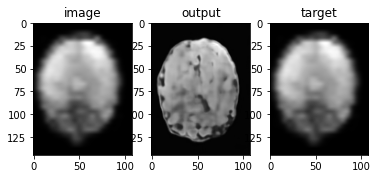

In [25]:
output_tensor = infer(model_unet_dhcp,image_tensor)
get_metrics(output_tensor,target_tensor,model_unet_dhcp)
plot_output(image_tensor,output_tensor,target_tensor)